<h1>Data Fitter</h1>

<h2>Select Data</h2>

In [1]:
import numpy as np
import scipy
from pandas import DataFrame as df
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import Button, Layout
from IPython.display import clear_output
import sys
import string
from lmfit import model, Model
from lmfit.models import PolynomialModel
import importlib

sys.path.insert(0, '../src/')
import AnalysisTools
importlib.reload(AnalysisTools)

data = AnalysisTools.DataTools()

##### Button Functions #####

def UpdateFiles_Clicked(b):
    Run = importlib.import_module(SelectRun.value.replace('.py',''), package=None)
    importlib.reload(Run)
    run = Run.Run()
    Par = run.Parameters(SelectRegion.value)
    SelectFile.options = data.FileList(Par['FolderPath'],Par['Runs'])

##### Widgets #####

SelectRun = widgets.Dropdown(
    options = data.FileList(os.getcwd(),'.py'),
    description = 'Select Run',
    layout = Layout(width='50%'),
    style = {'description_width': '150px'},
    disabled = False,
)

SelectRegion = widgets.Dropdown(
    options = ['Pi Star','Middle','Shape Resonance'],
    description = 'Select Run',
    layout = Layout(width='40%'),
    style = {'description_width': '150px'},
    disabled = False,
)

UpdateFiles = widgets.Button(description="Update",layout = Layout(width='10%'))
UpdateFiles.on_click(UpdateFiles_Clicked)

Run = importlib.import_module(SelectRun.value.replace('.py',''), package=None)
importlib.reload(Run)
run = Run.Run()
Par = run.Parameters(SelectRegion.value)

SelectFile = widgets.Dropdown(
    options=data.FileList(Par['FolderPath'],Par['Runs']),
    description='Select File',
    layout=Layout(width='50%'),
    style = {'description_width': '150px'},
    disabled=False,
)

display(widgets.Box([SelectRun,UpdateFiles]))
display(SelectFile)
display(SelectRegion)

Box(children=(Dropdown(description='Select Run', layout=Layout(width='50%'), options=('CO-O-Ru Hor 1-2.py', 'C…

Dropdown(description='Select File', layout=Layout(width='50%'), options=('XAS_018_020_D1000_E100.h5', 'XAS_018…

Dropdown(description='Select Run', layout=Layout(width='40%'), options=('Pi Star', 'Middle', 'Shape Resonance'…

<h2>Fit Data</h2>

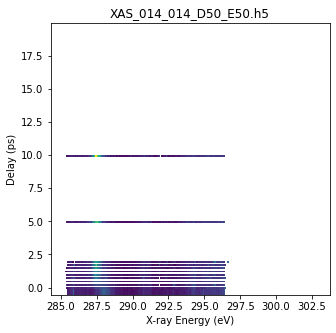

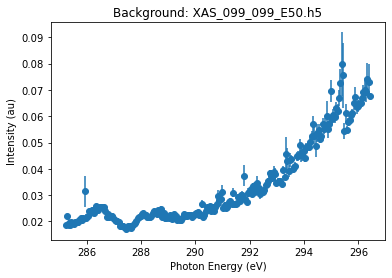

Button(description='Fit Data', style=ButtonStyle())

Output()

In [3]:
import AnalysisTools
importlib.reload(AnalysisTools)
data = AnalysisTools.DataTools()

global Energy, Signal, FitParameters

##### Button Functions #####

def ParametersToClipboard_Clicked(b):
    global FitParameters
    ToCopy = FitParameters
    ToCopy.to_clipboard()

def DataToClipboard_Clicked(b):
    global Energy, Delay, Signal
    ToCopy = Energy
    ToCopy = np.zeros((Signal.shape[0]+1,len(Energy)))
    ToCopy[0] = Energy
    i = 0
    while i < Signal.shape[0] :
        ToCopy[i+1] = Signal[i]
        i += 1
    ToCopy = np.transpose(ToCopy)
    ToCopy = df(data=ToCopy,columns=np.concatenate((['Energy'],Delay)))
    ToCopy.to_clipboard()
    print(Signal)
    
def FitData_Clicked(b):
    
    global Energy, Delay, Signal, FitParameters
    
    with out:
        
        clear_output(True)
        print('_'*110)
        print("")
        
        Run = importlib.import_module(SelectRun.value.replace('.py',''), package=None)
        importlib.reload(Run)
        run = Run.Run()
        Par = run.Parameters(SelectRegion.value)
        
        ##### Prepare data #####
        
        NumberPeaks = int(Par['NumPeaks'])
        NumRefPeaks = int(Par['NumRefPeaks'])
        ROI_Min = Par['ROI'][0]
        ROI_Max = Par['ROI'][1]
        Normalize = Par['Normalize']
        ScalingFactor = Par['ScalingFactor']
        
        Energy, Signal, Delay, ErrorBars = data.ImportData(Par['FolderPath'],SelectFile.value)
        if ScalingFactor != 1 :
            print('Warning, data is being scaled by '+str(ScalingFactor))
            Signal = Signal * ScalingFactor
            ErrorBars = ErrorBars * ScalingFactor
        Energy = Energy + Par['xOffset']
        if Par['BackgroundRun'] != 'None' :
            Background_Energy, Background, Background_Delay, Background_ErrorBars = data.ImportData(Par['FolderPath'],Par['BackgroundRun'])
            Background_Energy = Background_Energy + Par['xOffset']
        NormROI_Min, NormROI_Max = Par['NormROI']
        if Normalize == True :
            Energy, Signal = data.Normalize(Energy,Signal,Par['NormROI'][0], Par['NormROI'][1])
            if Par['BackgroundRun'] != 'None' :
                Background_Energy, Background = data.Normalize(Background_Energy,Background,Par['NormROI'][0], Par['NormROI'][1])
        Energy, Signal, Delay, ErrorBars = data.TrimData(Energy,Signal,Delay,ErrorBars,ROI_Min,ROI_Max)
        if Par['BackgroundRun'] != 'None' :
            Signal = data.SubtractBackground(Energy,Signal,Background_Energy,Background,ROI_Min,ROI_Max)

        ##### Plot all data #####
        
        Color = px.colors.qualitative.Dark24
        fig = go.Figure()
        for idx, array in enumerate(Signal) :
            fig.add_trace(go.Scatter(x=Energy,y=Signal[idx],mode='lines+markers',name=str(round(Delay[idx]))+' fs'))
        fig.update_layout(xaxis_title='Energy (eV)',yaxis_title='Intensity (au)',legend_title='')
        fig.show()
        
        if NumberPeaks != 0 or NumRefPeaks != 0 :

            print('_'*110)
            
            run.FitData(Energy,Delay,Signal,ErrorBars,SelectRegion.value,NumberPeaks,NumRefPeaks)
            
            FitParameters = run.FitParameters
            ParametersToClipboard = widgets.Button(description="Copy parameters")
            ParametersToClipboard.on_click(ParametersToClipboard_Clicked)
            
            DataToClipboard = widgets.Button(description="Copy data")
            DataToClipboard.on_click(DataToClipboard_Clicked)
            display(widgets.Box([DataToClipboard,ParametersToClipboard]))
        
        else :
            
            DataToClipboard = widgets.Button(description="Copy data")
            DataToClipboard.on_click(DataToClipboard_Clicked)
            display(DataToClipboard)

##### Parameters #####

Run = importlib.import_module(SelectRun.value.replace('.py',''), package=None)
importlib.reload(Run)
run = Run.Run()
Par = run.Parameters(SelectRegion.value)

Energy, Signal, Delay, ErrorBars = data.ImportData(Par['FolderPath'],SelectFile.value)
Energy = Energy + Par['xOffset']

##### Plot Data #####

plt.figure(figsize = [5,5])
plt.pcolor(Energy, Delay*1e-3, Signal)
plt.xlabel('X-ray Energy (eV)')
plt.ylabel('Delay (ps)')
plt.title(SelectFile.value)
plt.show()

if Par['BackgroundRun'] != 'None' :
    
    Background_Energy, Background, Background_Delay, Background_ErrorBars = data.ImportData(Par['FolderPath'],Par['BackgroundRun'])
    Background_Energy = Background_Energy + Par['xOffset']

    # Check data structure
    
    if Background.shape[0] != 1 :
        raise HaltException('Background data exceeds allowed dimensions')
    
    ##### Plot data #####
    
    # Background data
    x = Background_Energy
    y = Background[0]
    err = Background_ErrorBars[0]
    plt.plot(x, y,'r.', label='data')
    plt.errorbar(x, y, yerr=err, fmt='o')
    plt.xlabel('Photon Energy (eV)'), plt.ylabel('Intensity (au)')
    plt.title('Background: '+Par['BackgroundRun'])
    plt.show()

##### Fit data #####

FitData = widgets.Button(description="Fit Data")
FitData.on_click(FitData_Clicked)
display(FitData)

out = widgets.Output()
out

<h2>Calculate Lifetimes</h2>

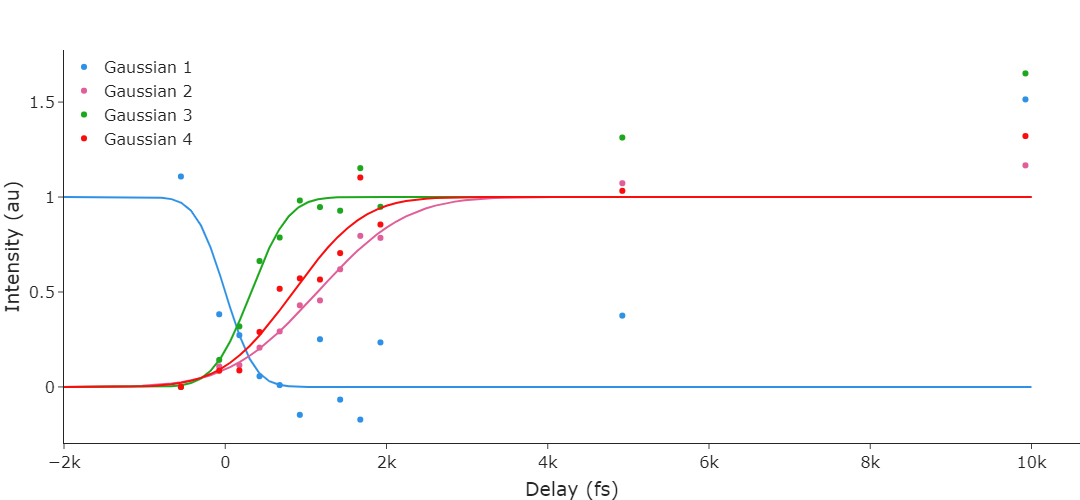

,a,b,t0,sigma
G1_amp,-0.004663,0.027021,0.000000,411.297931
G2_amp,0.005222,0.000000,1145.555956,1219.500749
G3_amp,0.007310,0.000000,320.465384,517.747985
G4_amp,0.007720,0.000000,843.274228,971.680000


Button(description='Copy Fit Parameters', style=ButtonStyle())

In [6]:
def func(t,a,b,t0,sigma):
    return a*scipy.special.erf((t-t0)/sigma)+a+b

def CopyTrends_Clicked(b):
    ToCopy = TrendParameters
    ToCopy.to_clipboard()

Run = importlib.import_module(SelectRun.value.replace('.py',''), package=None)
importlib.reload(Run)
run = Run.Run()
Par = run.Parameters(SelectRegion.value)

Parameters2Fit = FitParameters.copy()
Parameters2Fit = Parameters2Fit[Parameters2Fit.Delay > min(Par['TrendDelayRange'])]
Parameters2Fit = Parameters2Fit[Parameters2Fit.Delay < max(Par['TrendDelayRange'])]

FitModel = Model(func)
Parameters = FitModel.make_params()

Parameters['b'].min = 0
Parameters['t0'].min = 0
Parameters['sigma'].min = 0

TrendParameters = df(index=['a','b','t0','sigma'])
x = Parameters2Fit['Delay']
fit_x = np.linspace(-2000, 10000, 100)
fig = go.Figure()
FitsResults = list()
Color = px.colors.qualitative.Dark24
TrendNames = list()
for Name in Parameters2Fit.columns :
    if 'amp' in Name :
        TrendNames.append(Name)

for idx,column in enumerate(TrendNames) :
    if column in Par['TrendFits'] :
        Parameters['a'].value = Par['TrendFits'][column]['a']
        Parameters['b'].value = Par['TrendFits'][column]['b']
        Parameters['t0'].value = Par['TrendFits'][column]['t0']
        Parameters['sigma'].value = Par['TrendFits'][column]['sigma']
    y = Parameters2Fit[column]
    FitResults = FitModel.fit(y, Parameters, t=x)
    FitsResults.append(FitResults)
    fit_y = FitResults.eval(t=fit_x)
    Min = min(fit_y)
    Max = max(fit_y-Min)
    TrendParameters[column] = np.array((FitResults.params['a'].value,FitResults.params['b'].value,FitResults.params['t0'].value,FitResults.params['sigma'].value))
    fig.add_trace(go.Scatter(x=FitParameters['Delay'],y=(FitParameters[column]-Min)/Max,mode='markers',name=('Gaussian '+str(idx+1)),line_color=Color[idx]))
    fig.add_trace(go.Scatter(x=fit_x,y=(fit_y-Min)/Max,mode='lines',showlegend = False,line_color=Color[idx]))

fig.update_layout(xaxis_title='Delay (fs)',yaxis_title='Intensity (au)',font_size=16,legend_title='',width=800,height=500)
fig.show()
TrendParameters = TrendParameters.T
display(TrendParameters)

CopyTrends = widgets.Button(description="Copy Fit Parameters")
CopyTrends.on_click(CopyTrends_Clicked)
display(CopyTrends)

<h2>File info</h2>

This script fits Fermi data using Gaussian functions. 

Uses:
- lmfit
- plotly

-----------------------
Created by Jerry LaRue, larue@chapman.edu, 9/2018

Last modified by Jerry LaRue, larue@chapman.edu, 07/2020